In [1]:
from keras.datasets import mnist
from keras.layers import*
from keras.layers import LeakyReLU, Dense, Conv2D, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import math

In [2]:
(X_Train,_),(_,_) = mnist.load_data()

In [3]:
print(X_Train.shape)

(60000, 28, 28)


In [4]:
# Normalize this data [-1,1] 
X_Train  = (X_Train.astype('float32') - 127.5)/127.5
print(np.min(X_Train))
print(np.max(X_Train))

print(X_Train.shape)

-1.0
1.0
(60000, 28, 28)


In [5]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_Train.shape[0]/BATCH_SIZE) 
HALF_BATCH = 128
NOISE_DIM = 100 # Upsample into 784 Dim Vector

adam = Adam(learning_rate=2e-4, beta_1=0.5)

In [6]:
# Generator 
# Input Noise (100 dim) and Outputs a Vector (784 dim)

generator = Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()



C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Downsampling 
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# GAN (Step-2)
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)


In [9]:
X_Train = X_Train.reshape(-1,784)
print(X_Train.shape)

(60000, 784)


In [ ]:
def save_imgs(epoch,samples=100):
    
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

: 

In [ ]:
for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        # Randomly select 50% real images
        idx = np.random.randint(0, X_Train.shape[0], HALF_BATCH)
        real_imgs = X_Train[idx]
        
        # Generate 50% random images
        noise = np.random.normal(0, 1, size=(HALF_BATCH, NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        # One-sided label smoothing
        real_y = np.ones((HALF_BATCH, 1)) * 0.9  # Label Smoothing
        fake_y = np.zeros((HALF_BATCH, 1))
        
        # Train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)  # Updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = 0.5 * d_loss_real + 0.5 * d_loss_fake
        
        epoch_d_loss += d_loss
        
        # Train Generator (Complete Model Generator + Frozen Discriminator)
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
        real_y = np.ones((BATCH_SIZE, 1))  # Labels for generator training (want it to fool the discriminator)
        g_loss = model.train_on_batch(noise, real_y)
        
        # If g_loss is a list, extract the scalar loss value
        if isinstance(g_loss, list):
            g_loss = g_loss[0]  # Assuming the first value is the generator loss
        epoch_g_loss += g_loss
    
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    # Save the generator model and generate images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generator.save('models/gan_generator_{0}.h5'.format(epoch + 1))
        save_imgs(epoch)

       
        
        
        

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━

In [0]:
!mkdir images

In [0]:
!ls

images	model  sample_data


In [0]:
!zip -r /content/images.zip /content/images 

  adding: content/images/ (stored 0%)
  adding: content/images/gan_output_epoch_45.png (deflated 8%)
  adding: content/images/gan_output_epoch_15.png (deflated 8%)
  adding: content/images/gan_output_epoch_35.png (deflated 8%)
  adding: content/images/gan_output_epoch_30.png (deflated 8%)
  adding: content/images/gan_output_epoch_5.png (deflated 7%)
  adding: content/images/gan_output_epoch_50.png (deflated 8%)
  adding: content/images/gan_output_epoch_10.png (deflated 7%)
  adding: content/images/gan_output_epoch_40.png (deflated 8%)
  adding: content/images/gan_output_epoch_25.png (deflated 8%)
  adding: content/images/gan_output_epoch_20.png (deflated 8%)


In [0]:
from google.colab import files
files.download('images.zip')

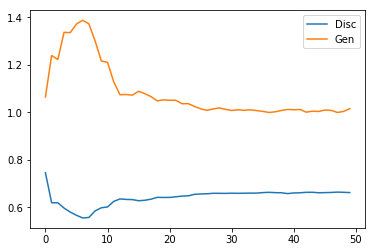

In [0]:
plt.plot(d_losses,label="Disc")
plt.plot(g_losses,label="Gen")
plt.legend()
plt.show()
